## Salinity, compare Double to Single

In [1]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

from salishsea_tools import viz_tools

DFO data from 2017 

In [2]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 0
dbin = 0.5
scale = 24

cmap = 'pink_r'#cm.rain #cm.ice_r #'ocean_r' #'pink_r'

In [294]:
foramt = "{:.3}"
myformat = {'bias': foramt, 'rmse': foramt, 'crmse':foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt, 'gamma2': foramt}

def use_f_2(x):
    return "%.2f" % x

In [4]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    deptht = mesh.gdept_1d[0].values
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')

In [5]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [6]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [7]:
def crmse(rmse, bias):
    return (np.sqrt(rmse**2 - bias**2))

In [303]:
def gamma2(rmse, df, obs):
    return (rmse**2/((df[obs]-df[obs].mean())**2).mean())

In [8]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [9]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
#    print (model.summary())
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [10]:
def wolfram_perp(df, obsin, modin):
    
    mod = np.array(df[modin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    obs = np.array(df[obsin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * df[obsin]
    
    nonsyst = np.sqrt(((df[modin] - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obsin])**2).mean())
  
    return a1, b1, systematic, nonsyst

In [11]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [435]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    if ('psf' in pieces[0]) | ('pug' in pieces[0]):
        temp1['DateTime'] = pd.to_datetime(temp1["dtUTC"], format="%Y-%m-%d %H:%M:%S")
        temp1['Month'] = temp1['DateTime'].dt.month
        temp1['Day'] = temp1['DateTime'].dt.day
    for piece in pieces[1:]:
        try:
            nextpiece = pd.read_csv(piece)
            if 'ferry' in piece:
                nextpiece['k'] = 0
            if ('psf' in piece) | ('pug' in piece):
                nextpiece['DateTime'] = pd.to_datetime(nextpiece["dtUTC"], format="%Y-%m-%d %H:%M:%S")
                nextpiece['Month'] = nextpiece['DateTime'].dt.month
                nextpiece['Day'] = nextpiece['DateTime'].dt.day
            temp1 = pd.concat([temp1, nextpiece], ignore_index=True)  
        except:
            print ('No file: ', piece)
#    temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
    return temp1

In [192]:
def filter_bad_data(temp1):
# bad data in Puget Sound (pugts)
    temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5) | (temp1.SA > 26) ]
# bad onc data
#    temp1_nobox_nohook = temp1_nohook[(temp1_nohook['depth (m)'] != 107) | (temp1_nohook.SA > 29)]
# bad ferry data
#    temp1_clean = temp1_nobox_nohook[((temp1_nobox_nohook.SA > 0.2) | (temp1_nobox_nohook.mod_vosaline - temp1_nobox_nohook.SA < 20)) 
#                                     & ((temp1_nobox_nohook.Lon > -123.8) | (temp1_nobox_nohook.SA > 14))]
    temp1_clean = temp1_nohook
    return temp1_clean

In [335]:
def plot_and_stats(temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):

    if boxes:
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)]
        shift_text = 1
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    counts, xedges, yedges, color = ax.hist2d(select[one], 
                                              select[two], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(),)# cmap=cmap);
    fig.colorbar(color, ax=ax)
   
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
    tgamma2 = gamma2(trmse, select, one)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
#    ax.plot(xr, c + m * xr, 'r-');
    ax.plot(xr, a1 + b1 * xr, 'r-')
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh
    ax.arrow(sc+vmin, bot+vmin, 0, sh-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(sc+vmin, top+vmin, 0, -sh+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(2*sc+vmin, bot+vmin, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(2*sc+vmin, top+vmin, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(3*sc+vmin, bot+vmin, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(3*sc+vmin, top+vmin, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread,
          'gamma2': tgamma2}
    ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2, counts


In [15]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''

    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [471]:
def plot_allyears(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, jjdepth, whichdepths, reverse=False):

    if reverse:
        string = '_reverse'
    else:
        string = ''
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    startyear = years[0]
    endyear = years[-1]
    fig.suptitle(f'Year {startyear}-{endyear}')
    pieces1 = []
    for year in years:
        pieces1.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ctd_{year}0101_{year}1231.csv')
        pieces1.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psfts_{year}0101_{year}1231.csv')
        pieces1.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pugts_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    d201905, counts1 = plot_and_stats(filter_bad_data(temp1[(temp1.Month == 6) & (temp1.Day <= maxday)]), 'single', idepth, jdepth, fig, axs[0], whichdepths, reverse, string)
    
    pieces2 = []
    year = years[0]
    for day in range(minday, maxday+1):
        pieces2.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_{year}06{day:02d}_{year}06{day+1:02d}.csv')
        pieces2.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_psfts_{year}06{day:02d}_{year}06{day+1:02d}.csv')
        pieces2.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_pugts_{year}06{day:02d}_{year}06{day+1:02d}.csv')
       
    pieces2.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_{year}0630_{year}0701.csv')
    pieces2.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_psfts_{year}0630_{year}0701.csv')
    pieces2.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_pugts_{year}0630_{year}0701.csv')
    temp2 = read_pieces(pieces2)
    d202111, counts2 = plot_and_stats(filter_bad_data(temp2), 'double', idepth, jjdepth, fig, axs[1], whichdepths, reverse, string)

    alltogether = pd.concat([d201905, d202111], axis=0)
    
    fig.savefig(f'{whichdepths}_{field}{string}_single_double_for_allyears.png')
    
    f = open(f'./{whichdepths}_{field}{string}_single_double_for_allyears_table.tex', 'w')
    f.write(alltogether.to_latex(column_format='lccccccccccc', 
            formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    f.close()
    return alltogether, counts1, counts2

## All Depths

No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170604_20170605.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170610_20170611.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170611_20170612.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170617_20170618.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170618_20170619.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170630_20170631.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_psfts_20170630_20170631.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_pugts_20170630_20170631.csv


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread,gamma2
single,58030,0.0886,0.675,0.669,0.0298,-0.0718,-2.04,0.164,0.68,-0.14,0.124
double,57793,0.11,0.664,0.655,0.0293,-0.0503,-1.38,0.146,0.665,-0.097,0.12


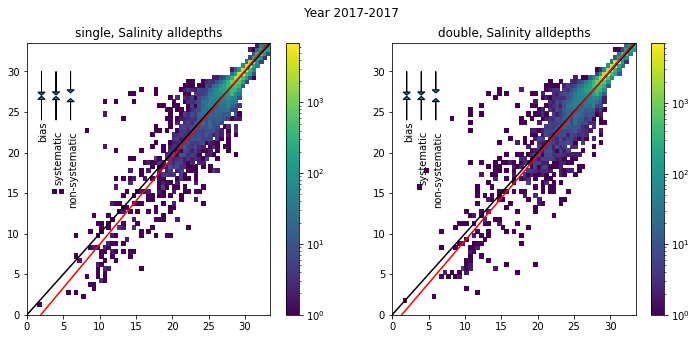

In [461]:
minday = 1
maxday = 30
idepth = 0
jdepth = 39
jjdepth = 79

results, counts1, counts2 = plot_allyears([2017]
                                          , []
                                          , []
                                       , [] 
                                       , [] 
                                          , idepth, jdepth, jjdepth, 'alldepths')
results.style.format(myformat).apply(highlight_max_min)

In [462]:
pieces1 = []
year = 2017

pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_single_psfts_{year}0101_{year}1231.csv')
pieces1.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_single_ctd_{year}0101_{year}1231.csv')
pieces1.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_single_pugts_{year}0101_{year}1231.csv')
temp1 = read_pieces(pieces1)
temp1 = filter_bad_data(temp1)

In [463]:
pieces2 = []
year = 2017

for day in range(minday, maxday+1):
    pieces2.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_{year}06{day:02d}_{year}06{day+1:02d}.csv')
    pieces2.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_psfts_{year}06{day:02d}_{year}06{day+1:02d}.csv')
    pieces2.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_pugts_{year}06{day:02d}_{year}06{day+1:02d}.csv')
print (pieces2[0])
pieces2.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_{year}0630_{year}0701.csv')
pieces2.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_psfts_{year}0630_{year}0701.csv')
pieces2.append(f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_pugts_{year}0630_{year}0701.csv')
temp2 = read_pieces(pieces2)
temp2 = filter_bad_data(temp2)

/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170601_20170602.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170604_20170605.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170610_20170611.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170611_20170612.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170617_20170618.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170618_20170619.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170630_20170631.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_psfts_20170630_20170631.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_pugts_20170630_20170631.csv


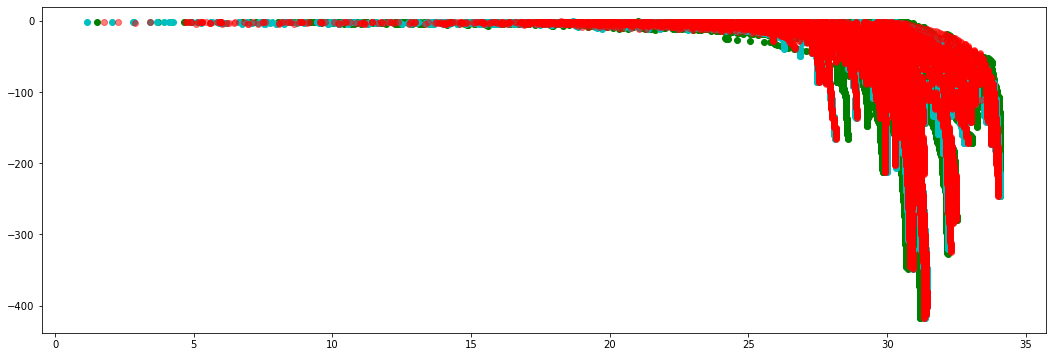

In [464]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
ax.plot(temp2.SA, -temp2.Z, 'go');
ax.plot(temp1.mod_vosaline[(temp1.Month == 6) & (temp1.Day >= minday)], 
        -temp1.Z[(temp1.Month == 6) & (temp1.Day >= minday)], 'co');
ax.plot(temp2.mod_vosaline, -temp2.Z, 'ro', alpha=0.5);

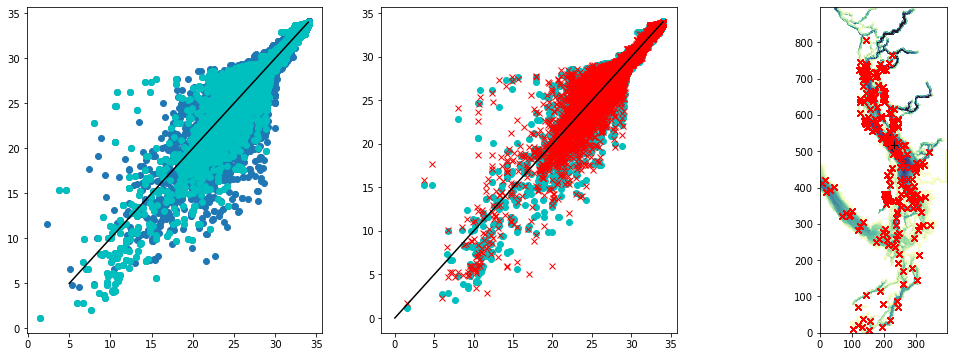

In [465]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].plot(temp1.SA, temp1.mod_vosaline, 'o')
axs[0].plot(temp1.SA[(temp1.Month == 6) & (temp1.Day <= maxday)], 
            temp1.mod_vosaline[(temp1.Month == 6) & (temp1.Day <= maxday)], 'co')
axs[0].plot(np.arange(5, 35), np.arange(5, 35), 'k')

axs[1].plot(temp1.SA[(temp1.Month == 6) & (temp1.Day <= maxday)], 
            temp1.mod_vosaline[(temp1.Month == 6) & (temp1.Day <= maxday)], 'co')
axs[1].plot(temp2.SA, temp2.mod_vosaline, 'rx')
axs[1].plot(np.arange(0, 35), np.arange(0, 35), 'k')
axs[2].pcolormesh(bathy.Bathymetry, cmap=cm.deep)
axs[2].plot(temp2.i/2, temp2.j/2, 'rx');
axs[2].plot(temp2.i[0:20]/2, temp2[0:20].j/2, 'k+');
viz_tools.set_aspect(axs[2]);

## Top 5 m

No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170604_20170605.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170610_20170611.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170611_20170612.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170617_20170618.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170618_20170619.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170630_20170631.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_psfts_20170630_20170631.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_pugts_20170630_20170631.csv


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread,gamma2
single,2324,-0.975,2.54,2.34,0.0763,-0.102,-3.49,1.08,2.42,-0.186,0.322
double,2330,-0.748,2.47,2.36,0.0758,-0.0639,-2.32,0.801,2.42,-0.114,0.307


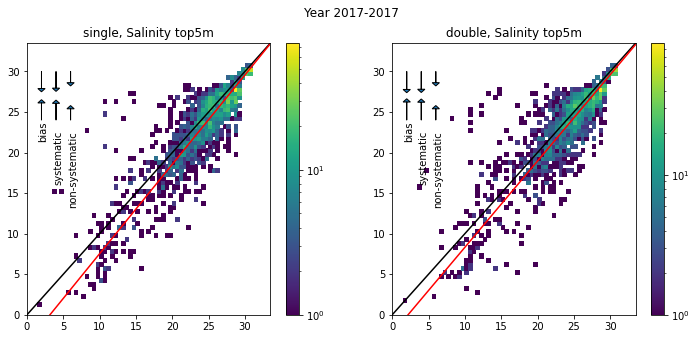

In [466]:
idepth = 0
jdepth = 5
jjdepth = 11

results, counts1, counts2 = plot_allyears([2017]
                                          , []
                                          , []
                                       , [] 
                                       , [] 
                                        ,  idepth, jdepth, jjdepth, 'top5m')
results.style.format(myformat).apply(highlight_max_min)

201905R

No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170604_20170605.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170610_20170611.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170611_20170612.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170617_20170618.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170618_20170619.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170630_20170631.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_psfts_20170630_20170631.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_pugts_20170630_20170631.csv


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread,gamma2
single,2324,-1.01,2.59,2.38,0.0752,-0.164,-5.06,1.25,2.48,-0.31,0.335
double,2330,-0.748,2.47,2.36,0.0758,-0.0639,-2.32,0.801,2.42,-0.114,0.307


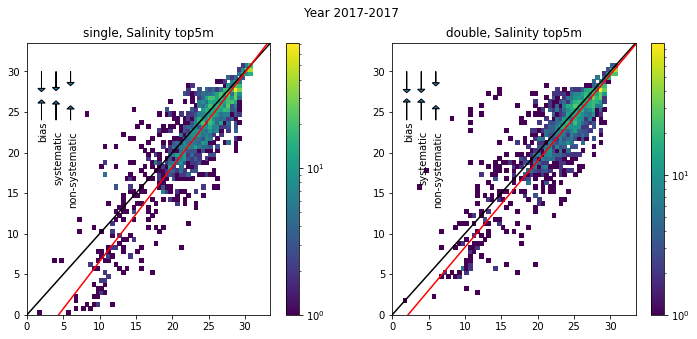

In [469]:
idepth = 0
jdepth = 5
jjdepth = 11

results, counts1, counts2 = plot_allyears([2017]
                                          , []
                                          , []
                                       , [] 
                                       , [] 
                                        ,  idepth, jdepth, jjdepth, 'top5m')
results.style.format(myformat).apply(highlight_max_min)

202111

No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170604_20170605.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170610_20170611.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170611_20170612.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170617_20170618.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170618_20170619.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_ctd_20170630_20170631.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_psfts_20170630_20170631.csv
No file:  /data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_double_pugts_20170630_20170631.csv


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread,gamma2
single,2324,-0.99,2.63,2.44,0.0818,-0.117,-3.86,1.12,2.54,-0.211,0.347
double,2330,-0.748,2.47,2.36,0.0758,-0.0639,-2.32,0.801,2.42,-0.114,0.307


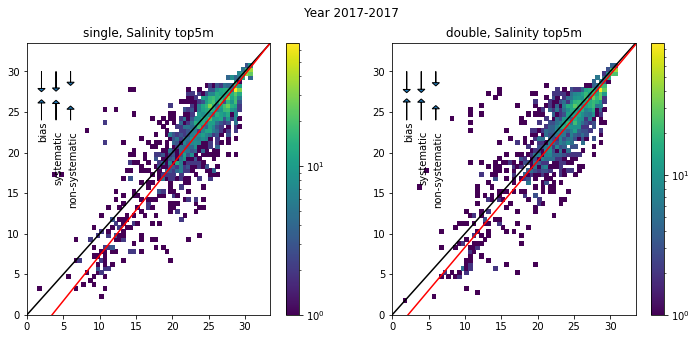

In [472]:
idepth = 0
jdepth = 5
jjdepth = 11

results, counts1, counts2 = plot_allyears([2017]
                                          , []
                                          , []
                                       , [] 
                                       , [] 
                                        ,  idepth, jdepth, jjdepth, 'top5m')
results.style.format(myformat).apply(highlight_max_min)

## Top 5 m: CTD Only

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,61995,-0.644,2.09,1.99,0.111,-0.169,-5.23,0.823,2.11,-0.291
202111,61950,-0.428,1.82,1.77,0.0853,-0.13,-3.97,0.583,1.85,-0.233


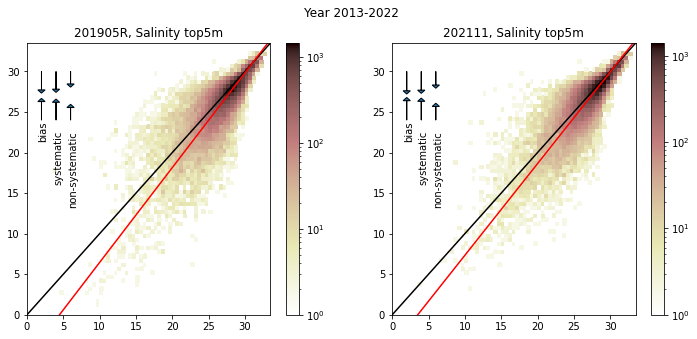

In [487]:
idepth = 0
jdepth = 5

results, counts1, counts2 = plot_allyears([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], 
                                          [2015, 2016, 2017, 2018], 
                                          [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],  
                                          [],
                                          idepth, jdepth, 'top5m')
results.style.format(myformat).apply(highlight_max_min)

## Below 5 m

,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,2088866,0.077,0.37,0.36,0.033,0.0096,0.37,0.078,0.36,0.018
202111,2088880,0.035,0.34,0.34,0.029,0.03,0.96,0.047,0.33,0.057


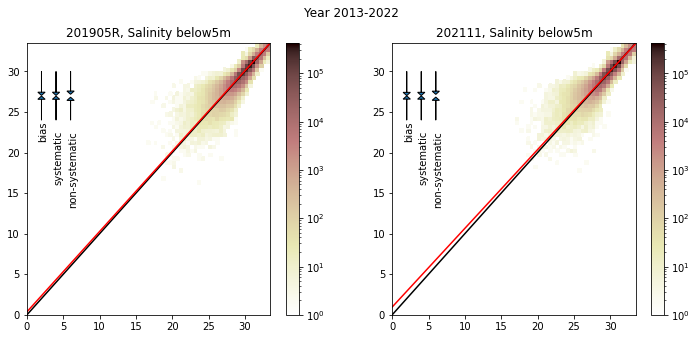

In [483]:
idepth = 5
jdepth = 39

results, counts1, counts2 = plot_allyears([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], 
                                          [2015, 2016, 2017], [2015, 2016, 2017, 2018], 
                                          [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022], 
                                          [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
                                          idepth, jdepth, 'below5m')
results.style.format(myformat).apply(highlight_max_min)

# Regionals

In [411]:
def stats_only(temp1, name, idepth, jdepth, corn, boxname):
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
    number, tbias = bias(select, obsn, modn)
    if number > 0:
        trmse = rmse(select, obsn, modn)
        tcrmse = crmse(trmse, tbias)
        tswillmott = swillmott(select, obsn, modn)
        a1, b1, syst, nonsyst = wolfram_perp(select, obsn, modn)
        tspread = spread(select, obsn, modn)
        Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread,
          'region': boxname}
        dCp2 = pd.DataFrame(data=Cp2, index=[name])
    else:
        dCp2 = 0
    return number, dCp2

In [449]:
def stats_allregions(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths):
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')    
    for year in years_ferry:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')    
    temp1 = read_pieces(pieces1)
    
    number, alltogether = stats_only(filter_bad_data(temp1), '201905R', idepth, jdepth, boxes[0], boxnames[0])
    for boxname, corn in zip(boxnames[1:], boxes[1:]):
        number, d201905 = stats_only(filter_bad_data(temp1), '201905R', idepth, jdepth, corn, boxname)
        if number > 0:
            alltogether = pd.concat([alltogether, d201905], axis=0)

    pieces2 = []
    for year in years:
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ferry_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)
   
    for boxname, corn in zip(boxnames, boxes):
        number, d202111 = stats_only(filter_bad_data(temp2), '202111', idepth, jdepth, corn, boxname)
        if number > 0:
            alltogether = pd.concat([alltogether, d202111], axis=0)
    f = open(f'./{whichdepths}_{field}_201905_202111_for_allregions_table.tex', 'w')
    f.write(alltogether.to_latex(column_format='lccccccccccl', 
            formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, None]))
    f.close()
    return alltogether

In [450]:
def stats_and_plot(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, box, boxname, whichdepths):
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    fig.suptitle(f'{boxname} Year {years[0]}-{years[-1]}')
    
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')   
    for year in years_ferry:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')   
    temp1 = read_pieces(pieces1)
    
    alltogether, counts = plot_and_stats(filter_bad_data(temp1), '201905R', idepth, jdepth, fig, axs[0], whichdepths, False, '', boxes=True, box=box, boxname=boxname)

    pieces2 = []
    for year in years:
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ferry_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)
    d202111, counts = plot_and_stats(filter_bad_data(temp2), '202111', idepth, jdepth, fig, axs[1], whichdepths, False, '', boxes=True, box=box, boxname=boxname)
    
    plot_profiles(temp1, temp2, axs[2], axs[3], box, boxname)
    
    
    alltogether = pd.concat([alltogether, d202111], axis=0)

In [428]:
def plot_profiles(temp1, temp2, ax, ax2, box, boxname):

    corn = box
    temp1['diff'] = temp1[modn] - temp1[obsn]
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
    kls = len(select.groupby('k')[obsn])
    ax.plot(select.groupby('k')[obsn].mean(), deptht[:kls], 'o-', c='tab:green', label='Observations')
    ax.plot(select.groupby('k')[modn].mean(), deptht[:kls], 'o-', c='tab:blue', label='201905')
    ax2.plot(select.groupby('k')['diff'].mean(), deptht[:kls], '-', c='tab:blue', label='201905')
    ax.fill_betweenx(deptht[:kls], select[['k', modn]].groupby('k').quantile(q=0.25)[modn], select[['k', modn]].groupby('k').quantile(q=0.75)[modn], alpha=0.2, color='tab:blue')
    ax2.fill_betweenx(deptht[:kls], select[['k', 'diff']].groupby('k').quantile(q=0.25)['diff'], select[['k', 'diff']].groupby('k').quantile(q=0.75)['diff'], alpha=0.2, color='tab:blue')
    
    temp2['diff'] = temp2[modn] - temp2[obsn]
    select = temp2[(temp2.k >= idepth) & (temp2.k <= jdepth) &
                              (temp2.j >= corn[0]) & (temp2.j <= corn[1]) &
                              (temp2.i >= corn[2]) & (temp2.i <= corn[3])]
    
    ax.plot(select.groupby('k')[modn].mean(), deptht[:kls], 'o-', c='tab:orange', label='202111')
    ax2.plot(select.groupby('k')['diff'].mean(), deptht[:kls], '-', c='tab:orange', label='202111')
    ax.fill_betweenx(deptht[:kls], select[['k', modn]].groupby('k').quantile(q=0.25)[modn], select[['k', modn]].groupby('k').quantile(q=0.75)[modn], alpha=0.2, color='tab:orange')
    ax.fill_betweenx(deptht[:kls], select[['k', obsn]].groupby('k').quantile(q=0.25)[obsn], select[['k', obsn]].groupby('k').quantile(q=0.75)[obsn], alpha=0.2, color='tab:orange')
    ax2.fill_betweenx(deptht[:kls], select[['k', 'diff']].groupby('k').quantile(q=0.25)['diff'], select[['k', 'diff']].groupby('k').quantile(q=0.75)['diff'], alpha=0.2, color='tab:orange')
    
    ax.invert_yaxis()
    ax2.invert_yaxis()
    
    ax.legend()
    ax2.legend()
    ax.set_title(f'{field} Profiles')
    ax2.set_title(f'{field} Difference Profiles')
    ax2.grid();

In [374]:
def plot_box(ax, corn, colour):
    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
            [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)

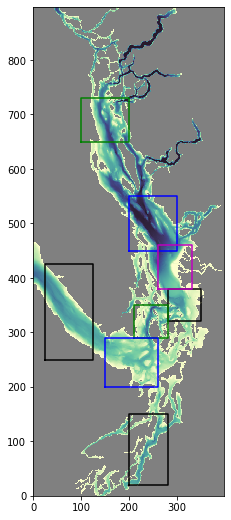

In [426]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
viz_tools.set_aspect(ax);
SoG_center = [450, 550, 200, 300]
plot_box(ax, SoG_center, 'b')
SoG_north = [650, 730, 100, 200]
plot_box(ax, SoG_north, 'g')
SoG_south = [320, 380, 280, 350]
plot_box(ax, SoG_south, 'k')
Haro_Boundary = [290, 350, 210, 280]
plot_box(ax, Haro_Boundary, 'g')
JdF_east = [200, 290, 150, 260]
plot_box(ax, JdF_east, 'b')
JdF_west = [250, 425, 25, 125]
plot_box(ax, JdF_west, 'k')
PS_main = [20, 150, 200, 280]
plot_box(ax, PS_main, 'k')
SS_all = [0, 898, 0, 398]
boxes = [SS_all, SoG_south,SoG_center, SoG_north, PS_main, Haro_Boundary, JdF_west, JdF_east]
boxnames = ['SS_all', 'SoG_south', 'SoG_center', 'SoG_north', 'PS_main', 'Haro_Boundary',
           'JdF_west', 'JdF_east']
Fraser_plume = [380, 460, 260, 330]
plot_box(ax, Fraser_plume, 'm')

## All Depths

In [478]:
idepth = 0
jdepth = 39

results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
                           [2015, 2016, 2017, 2018, 2019],
                           idepth, jdepth, 'alldepths')
for boxname in boxnames:
    if results[results.region == boxname].number[0] > 0:
        print(f'\033[1m{boxname}\033[1m')
        display(results[results.region == boxname].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

SS_all


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,2772757,0.14,2.5,2.5,0.068,0.05,1.6,0.3,2.5,0.087
202111,2772729,0.25,2.1,2.1,0.05,0.1,3.1,0.58,2.0,0.18


SoG_south


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,46597,0.09,0.49,0.49,0.052,-0.029,-0.78,0.096,0.49,-0.053
202111,46597,0.059,0.47,0.46,0.048,0.019,0.62,0.063,0.46,0.034


SoG_center


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,681906,-0.26,2.5,2.5,0.093,-0.069,-2.2,0.39,2.6,-0.12
202111,681905,-0.068,2.3,2.3,0.076,-0.038,-1.1,0.17,2.3,-0.065


SoG_north


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,220535,0.18,0.45,0.41,0.045,-0.035,-0.86,0.19,0.41,-0.067
202111,220542,0.15,0.4,0.37,0.039,0.047,1.6,0.16,0.36,0.086


PS_main


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,48823,0.1,0.54,0.53,0.13,-0.0037,-0.0057,0.1,0.53,-0.0057
202111,48823,0.15,0.53,0.51,0.1,-0.25,-7.2,0.25,0.54,-0.45


Haro_Boundary


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,42328,-0.066,0.37,0.37,0.047,-0.067,-2.2,0.087,0.38,-0.13
202111,42328,-0.09,0.35,0.34,0.041,-0.058,-1.9,0.1,0.34,-0.11


JdF_west


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,25283,-0.087,0.41,0.4,0.037,-0.015,-0.59,0.089,0.41,-0.029
202111,25283,-0.09,0.39,0.38,0.033,-0.021,-0.77,0.093,0.38,-0.039


JdF_east


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,65390,-0.088,0.41,0.4,0.052,-0.0022,-0.16,0.088,0.4,-0.004
202111,65390,-0.11,0.37,0.36,0.042,-0.026,-0.92,0.11,0.36,-0.048


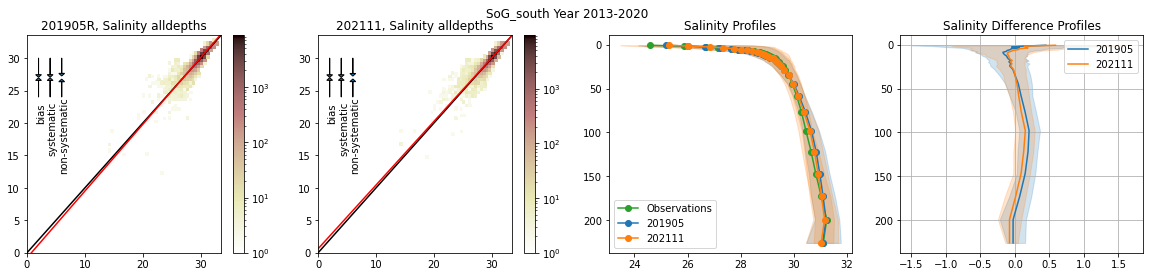

In [479]:
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
               [2015, 2016, 2017, 2018, 2019],
               idepth, jdepth, SoG_south, 'SoG_south', 'alldepths')

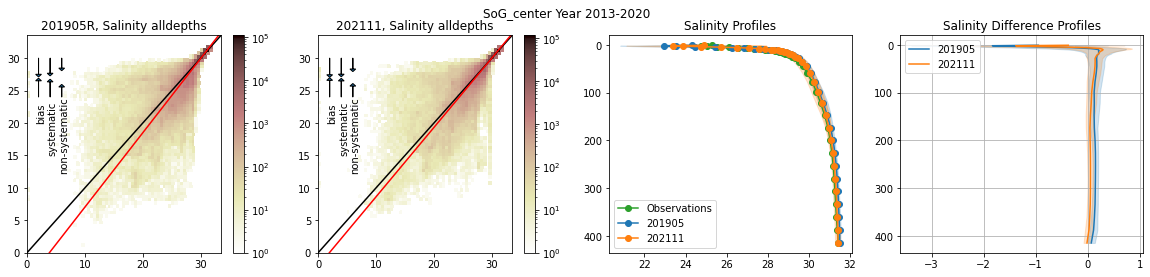

In [469]:
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
               [2015, 2016, 2017, 2018, 2019],
               idepth, jdepth, SoG_center, 'SoG_center', 'alldepths')

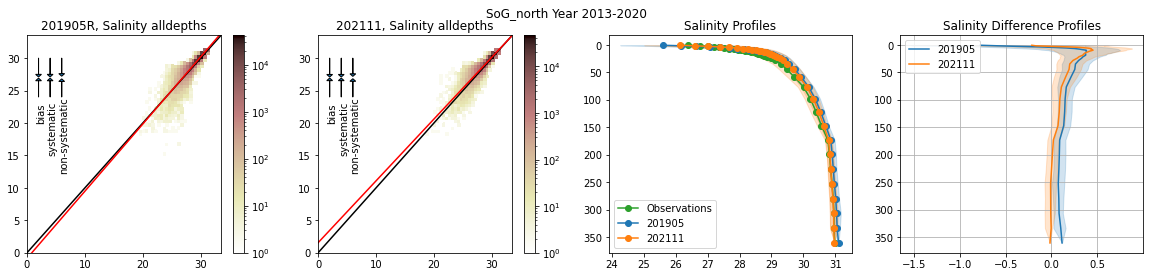

In [470]:
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], [2018, 2019],
               idepth, jdepth, SoG_north, 'SoG_north', 'alldepths')

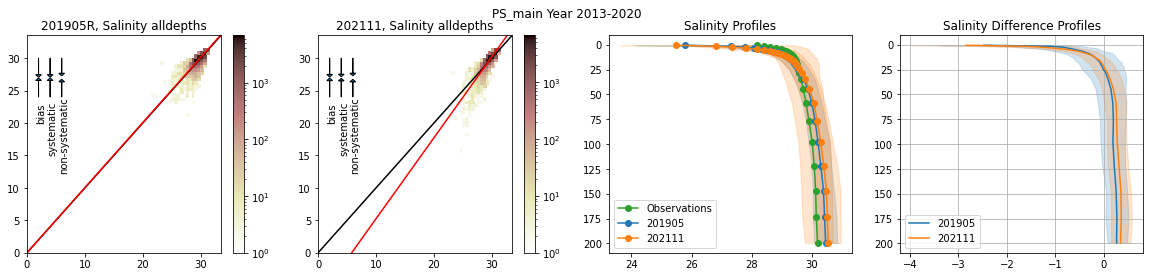

In [456]:
idepth = 0
jdepth = 39
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], [2019],
               idepth, jdepth, PS_main, 'PS_main', 'alldepths')

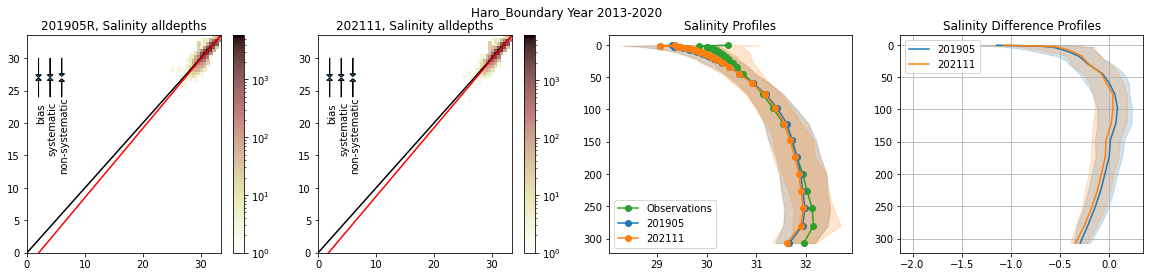

In [457]:
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], [2019],
               idepth, jdepth, Haro_Boundary, 'Haro_Boundary', 'alldepths')

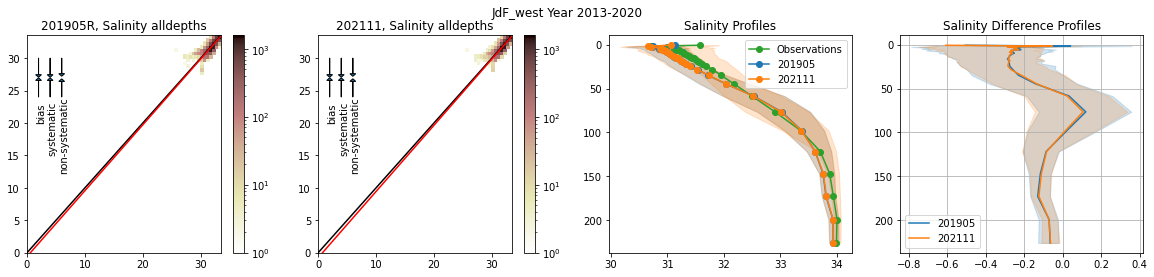

In [458]:
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], [2019],
               idepth, jdepth, JdF_west, 'JdF_west', 'alldepths')

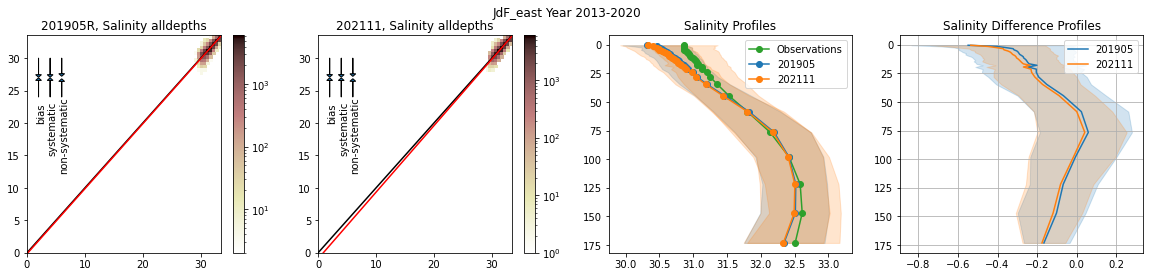

In [459]:
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], [2019],
               idepth, jdepth, JdF_east, 'JdF_east', 'alldepths')

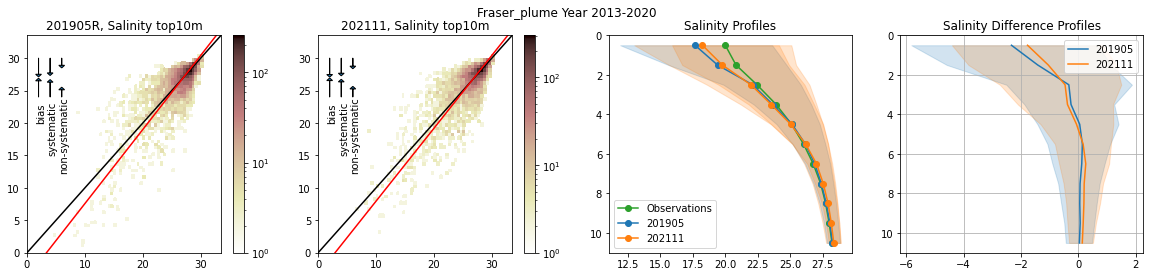

In [460]:
idepth = 0
jdepth = 10
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], [],
               idepth, jdepth, Fraser_plume, 'Fraser_plume', 'top10m')

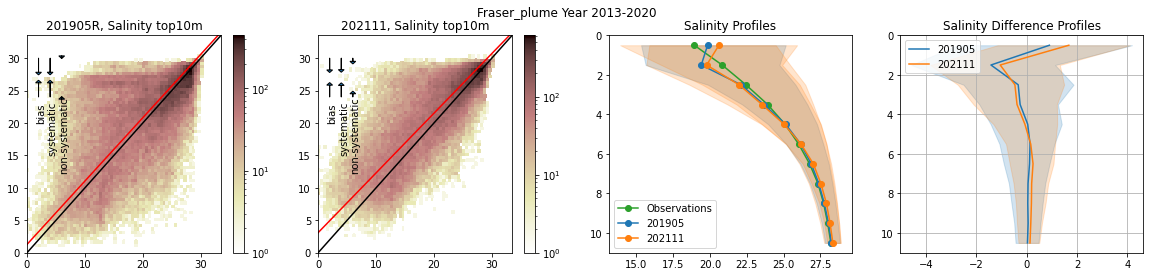

In [461]:
idepth = 0
jdepth = 10
stats_and_plot([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], [2019],
               idepth, jdepth, Fraser_plume, 'Fraser_plume', 'top10m')

## Above 5 m

In [383]:
idepth = 0
jdepth = 5

results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
                           idepth, jdepth, 'top5m')
for boxname in boxnames:
    if results[results.region == boxname].number[0] > 0:
        print(f'\033[1m{boxname}\033[1m')
        display(results[results.region == boxname].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

SS_all


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,62019,-0.64,2.1,0.11,-0.16,-5.1,0.81,2.1,-0.28
202111,61974,-0.42,1.8,0.086,-0.13,-3.8,0.57,1.9,-0.23


SoG_south


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1431,0.019,1.9,0.11,0.026,0.72,0.082,1.9,0.048
202111,1431,0.14,1.9,0.11,0.12,3.4,0.39,1.7,0.19


SoG_center


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,6708,-1.1,2.7,0.14,-0.21,-6.6,1.4,2.6,-0.36
202111,6708,-0.79,2.4,0.11,-0.21,-6.2,1.1,2.4,-0.37


SoG_north


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,10129,-0.26,1.4,0.15,-0.49,-1.3e+01,0.81,1.5,-0.86
202111,10129,0.096,1.2,0.13,-0.29,-7.7,0.47,1.3,-0.5


PS_main


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1975,-0.87,1.6,0.3,-0.14,-4.8,0.89,1.4,-0.17
202111,1975,-1.2,1.8,0.23,-0.73,-2.2e+01,1.5,1.4,-1.5


Haro_Boundary


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1013,-0.62,0.97,0.2,-0.12,-4.4,0.63,0.78,-0.2
202111,1013,-0.57,0.88,0.16,-0.13,-4.4,0.59,0.7,-0.22


JdF_west


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,778,-0.22,0.93,0.34,0.54,1.7e+01,0.61,0.59,0.59
202111,778,-0.24,0.84,0.26,0.44,1.4e+01,0.52,0.56,0.54


JdF_east


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,2907,-0.35,0.64,0.28,-0.29,-9.2,0.39,0.6,-0.38
202111,2907,-0.39,0.57,0.2,-0.24,-7.8,0.42,0.44,-0.41


## Below 5 m

In [384]:
idepth = 5
jdepth = 39

results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
                           idepth, jdepth, 'below5m')
for boxname in boxnames:
    if results[results.region == boxname].number[0] > 0:
        print(f'\033[1m{boxname}\033[1m')
        display(results[results.region == boxname].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

SS_all


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,1976508,0.084,0.38,0.033,0.0062,0.27,0.084,0.37,0.011
202111,1976522,0.043,0.34,0.028,0.027,0.85,0.051,0.33,0.049


SoG_south


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,45459,0.092,0.38,0.053,-0.051,-1.5,0.1,0.38,-0.094
202111,45459,0.057,0.36,0.047,-0.019,-0.52,0.059,0.35,-0.035


SoG_center


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,330495,0.14,0.31,0.03,0.027,0.95,0.15,0.28,0.05
202111,330495,0.083,0.27,0.024,0.067,2.1,0.1,0.24,0.13


SoG_north


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,212185,0.21,0.35,0.047,0.11,3.5,0.23,0.26,0.2
202111,212192,0.16,0.33,0.042,0.14,4.2,0.2,0.24,0.24


PS_main


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,47227,0.14,0.45,0.13,0.18,5.4,0.19,0.38,0.27
202111,47227,0.2,0.41,0.09,0.03,1.1,0.2,0.35,0.051


Haro_Boundary


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,41521,-0.054,0.35,0.045,-0.041,-1.3,0.064,0.35,-0.076
202111,41521,-0.08,0.33,0.039,-0.035,-1.2,0.085,0.32,-0.065


JdF_west


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,24686,-0.084,0.39,0.035,-0.019,-0.71,0.086,0.38,-0.035
202111,24686,-0.086,0.37,0.031,-0.024,-0.87,0.09,0.37,-0.043


JdF_east


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
201905R,63078,-0.078,0.39,0.05,0.016,0.44,0.079,0.38,0.027
202111,63078,-0.098,0.36,0.041,-0.0076,-0.34,0.098,0.35,-0.016
